<a href="https://colab.research.google.com/github/Simon-delalande/Using-persistent-homology-and-transformers-for-classification-/blob/main/attention_TDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install gudhi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 28.7 MB 10.6 MB/s 


In [3]:
from os import chdir
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import pandas as pd
import pickle as pickle
import math
import gudhi as gd
from sklearn import preprocessing

import tensorflow as tf 
import keras
from keras.layers import Dense, MultiHeadAttention, LayerNormalization, Dropout


# Data preparation


The walk of 3 persons A, B and C, has been recorded using the accelerometer sensor of a smartphone in their pocket, giving rise to 3 multivariate time series in : each time series represents the 3 coordinates of the acceleration of the corresponding walker in a coordinate system attached to the sensor.

Notice that the smartphone was carried in a possibly different position for each person and thus these time series cannot be compared coordinates by coordinates.



We will try here to predict from which person a point cloud comes from by using a classification algorithm on the persistent diagram of the point cloud. 

Such diagrams can be seen as a sequence of vectors in R^2, but with no particular order. We will thus use an attention model, inspired by BERT, which can procede sequences of any lengths of vectors and map the interactions between them. 

In [27]:
f = open("/content/drive/MyDrive/data_acc","rb")
data = pickle.load(f)    
f.close()

In [28]:
data_A = data[0]
data_B = data[1] 
data_C = data[2]
label  = data[3]

In [33]:
data_all= np.reshape(data[0:3], (300, 200, 3))

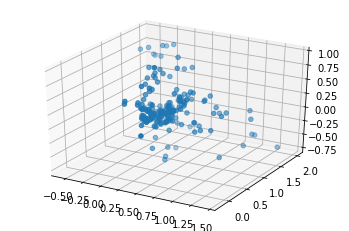

In [29]:
data_A_sample = data_A[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(data_A_sample[:, 0], data_A_sample[:, 1], data_A_sample[:, 2]);

The labels are one hot encoded to perform the classification 

In [30]:
def convert_label(label):
  A= np.zeros((label.shape[0], 3))
  for i in range(label.shape[0]):
    if label[i] == 'A': A[i,:]= np.array([1.0, 0.0, 0.0])
    elif label[i] == 'B': A[i,:] = np.array([0.0, 1.0, 0.0])
    else: A[i,:] = np.array([0.0, 0.0, 1.0])

  return(A)

labels= convert_label(label)

The homological features with an inf death time are removed. In this case it correspond only to the largest connex component, which is present in all diagram so no information is lost. 

In [31]:
def remove_inf(array):
  L= []
  l=0
  for i in array:
    if i[1]== math.inf:
      L.append(l)
    l+=1

  array= np.delete(array, L, 0)
  return array

Each point cloud is transformed into a persistent diagram

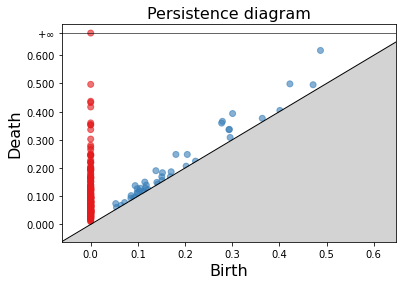

In [48]:
skeleton= gd.RipsComplex(points= data_A[0], max_edge_length= 1)
rips_simplex_tree= skeleton.create_simplex_tree(max_dimension= 2)
bar_code= rips_simplex_tree.persistence()

gd.plot_persistence_diagram(bar_code)


In [32]:
max_edge_length= 1.5
max_dim= 2

def preprocess(data_sample):

  skeleton= gd.RipsComplex(points= data_sample, max_edge_length= max_edge_length)
  Rips_simplex_tree= skeleton.create_simplex_tree(max_dimension= max_dim)
  Rips_simplex_tree.compute_persistence(2)
  return remove_inf(np.concatenate((Rips_simplex_tree.persistence_intervals_in_dimension(0), Rips_simplex_tree.persistence_intervals_in_dimension(1))))

In order for our model to process batches of data, all diagrams must have the same length. We thus pad the diagrams (seen as a sequence of R2 vectors). 

In [34]:
max_size= 0
for i in data_all:
  size= preprocess(i).shape[0]
  if size> max_size:
    max_size= size

print(max_size)

275


Here  max_size= 275

In [35]:
def padd(persistence, max_size):
  assert persistence.shape[0] <= max_size
  pad= np.zeros((max_size-persistence.shape[0], 2))
  return np.concatenate((persistence, pad))

In [36]:
final_data= np.zeros((300,275,2))
l=0
for i in data_all:
  final_data[l,:,:]= padd(preprocess(i), max_size)
  l+=1

A classification token is added at the end of the diagrams, on which the classification will be done 

In [37]:
def add_cls_token(data):
  token= np.ones(shape= (300, 1,2))
  token *= 1.5
  data_cls= np.concatenate((data, token), axis= 1)
  return data_cls


processed_data= add_cls_token(final_data)

In [38]:
with open('parrot.pkl', 'wb') as f:
  pickle.dump(processed_data, f)

In [41]:
f= open("/content/drive/MyDrive/parrot.pkl", "rb") #to avoid to recalculate the persistent homology each time I run the notebook
processed_data= pickle.load(f)
f.close()

In [42]:
processed_data.shape

(300, 276, 2)

The data is centered and normalized, which has tremendous effect on the model's performances. 

In [20]:
X= np.reshape(processed_data, (300,-1))
X= preprocessing.StandardScaler().fit_transform(X)
X= np.reshape(X, (300,276,2))

It is then shuffled and split into a train and a test set

In [21]:
idx = np.random.permutation(300)
x,y = X[idx], labels[idx]

In [22]:
test_size= 40
X_train, y_train= x[test_size:,:,:], y[test_size:, :]
X_test, y_test= x[0:test_size,:,:], y[0:test_size,:]

# Model creation

Model creation:
The model is a succession of transformers encoders units. 
Here, the use of layer normalization impede the model to learn for an unknown reason. It has thus been removed. 

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):

    def __init__(self, num_heads,  embedding_dim, fully_connected_dim =2,
                 layernorm_eps=1e-6):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads=num_heads,
                                      key_dim=embedding_dim)

        self.ffn1 = Dense(fully_connected_dim, activation='relu')
        self.ffn2= Dense(embedding_dim)

        self.layernorm1 = LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = LayerNormalization(epsilon=layernorm_eps)
        self.inp= keras.Input(shape=(276,2))
        #self.dropout_ffn = Dropout(dropout_rate)
    
    def call(self, x):

        attn_output = self.mha(x, x)

        #out1 = self.layernorm1(attn_output+ x)  
        out1= attn_output+x
        
        ffn_output = self.ffn1(out1) 
        ffn_output= self.ffn2(ffn_output)
        

        #encoder_layer_out = self.layernorm2(ffn_output+out1) 
        encoder_layer_out= ffn_output+ out1

        return encoder_layer_out
    

A classification layer with two dense layers is added on top of the mutiple encoders

In [ ]:
class Encoder(tf.keras.Model):

    def __init__(self, num_layers, embedding_dim, num_heads, fully_connected_dim, clf_dim,
                layernorm_eps=1e-6):
        super(Encoder, self).__init__()

        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        self.enc_layers = [EncoderLayer(embedding_dim=self.embedding_dim,
                                        num_heads=num_heads,
                                        fully_connected_dim=fully_connected_dim,
                                        layernorm_eps=layernorm_eps) 
                           for _ in range(self.num_layers)]

        #self.dropout = Dropout(dropout_rate)
        self.clf1= Dense(clf_dim, activation= 'relu')
        self.clf2= Dense(3, 'softmax')
        
    def call(self, x):

        seq_len = tf.shape(x)[1]
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        z= x[:,seq_len-1,:]
        z= self.clf1(z)
        z= self.clf2(z)


        return z  

In [ ]:
model= Encoder(num_layers= 16, embedding_dim=2, num_heads=1, fully_connected_dim=256, clf_dim=256)

In [ ]:
model.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [ ]:
history= model.fit(x= X_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
15/15 [==============================] - 9s 146ms/step - loss: 1.7652 - accuracy: 0.5684 - val_loss: 0.9207 - val_accuracy: 0.4615
Epoch 2/50
15/15 [==============================] - 1s 47ms/step - loss: 0.9576 - accuracy: 0.6368 - val_loss: 0.8296 - val_accuracy: 0.6154
Epoch 3/50
15/15 [==============================] - 1s 47ms/step - loss: 0.8012 - accuracy: 0.6667 - val_loss: 0.7011 - val_accuracy: 0.6923
Epoch 4/50
15/15 [==============================] - 1s 47ms/step - loss: 0.6930 - accuracy: 0.6880 - val_loss: 0.6262 - val_accuracy: 0.6923
Epoch 5/50
15/15 [==============================] - 1s 48ms/step - loss: 0.6046 - accuracy: 0.7137 - val_loss: 0.5665 - val_accuracy: 0.7308
Epoch 6/50
15/15 [==============================] - 1s 47ms/step - loss: 0.5636 - accuracy: 0.8077 - val_loss: 0.5446 - val_accuracy: 0.7308
Epoch 7/50
15/15 [==============================] - 1s 47ms/step - loss: 0.4676 - accuracy: 0.8034 - val_loss: 0.4446 - val_accuracy: 0.8846
Epoch 8/50
1

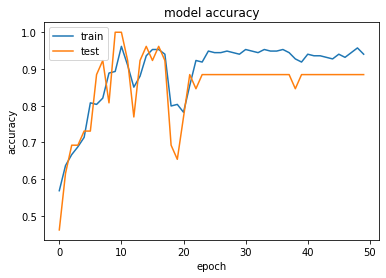

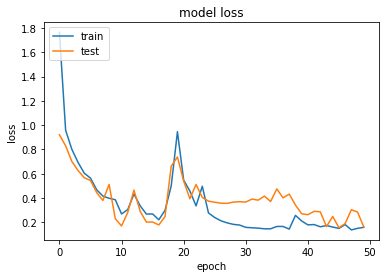

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing the model 

In [ ]:
results = model.evaluate(X_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 25ms/step - loss: 0.3021 - accuracy: 0.9000
[0.30213460326194763, 0.8999999761581421]


We get an accuracy of 0.9 on the test set. It is pretty good considering that we are only using topological informations about the data in order to classify it. 

# Classical model

We use the same model architecture on the raw data extracted from the sensors to compare the performances

In [ ]:
x,y = data_all[idx], labels[idx]

In [ ]:
def add_cls_token(data):
  token= np.zeros(shape= (300, 1,3))
  data_cls= np.concatenate((data, token), axis= 1)
  return data_cls


x= add_cls_token(x)

In [ ]:
x.shape

(300, 201, 3)

In [ ]:
x= np.reshape(x, (300,-1))
x= preprocessing.StandardScaler().fit_transform(x)
x= np.reshape(x, (300,201,3))

In [ ]:
test_size= 40
x_test, y_test= x[:test_size], y[:test_size]
x_train, y_train= x[test_size:], y[test_size:]


In [ ]:
model2= Encoder(num_layers= 16, embedding_dim=3, num_heads=1, fully_connected_dim=256, clf_dim=256)

In [ ]:
model2.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [ ]:
history= model2.fit(x= x_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
15/15 [==============================] - 18s 506ms/step - loss: 2.3035 - accuracy: 0.2650 - val_loss: 0.7233 - val_accuracy: 0.5000
Epoch 2/50
15/15 [==============================] - 5s 358ms/step - loss: 0.8551 - accuracy: 0.5427 - val_loss: 0.6392 - val_accuracy: 0.6923
Epoch 3/50
15/15 [==============================] - 5s 342ms/step - loss: 0.7387 - accuracy: 0.6838 - val_loss: 0.5414 - val_accuracy: 0.9231
Epoch 4/50
15/15 [==============================] - 5s 356ms/step - loss: 0.6055 - accuracy: 0.8504 - val_loss: 0.4339 - val_accuracy: 0.9231
Epoch 5/50
15/15 [==============================] - 5s 356ms/step - loss: 0.5440 - accuracy: 0.8248 - val_loss: 0.4804 - val_accuracy: 0.8462
Epoch 6/50
15/15 [==============================] - 5s 366ms/step - loss: 0.5572 - accuracy: 0.7863 - val_loss: 0.4104 - val_accuracy: 0.8077
Epoch 7/50
15/15 [==============================] - 9s 631ms/step - loss: 0.6426 - accuracy: 0.7863 - val_loss: 0.5496 - val_accuracy: 0.8077
Epoch

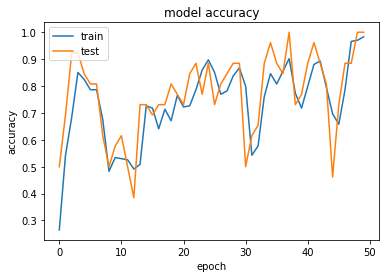

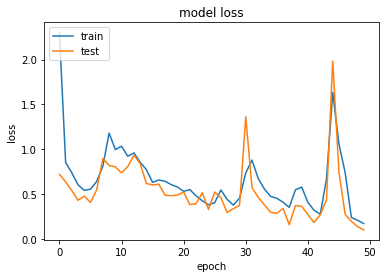

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
results = model2.evaluate(x_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 95ms/step - loss: 0.4637 - accuracy: 0.8750
[0.4637420177459717, 0.875]


# Diagram Vectorization 

The transformer's architecture enabled us to use the persistence diagrams without having to convert them to a fixed length vector. 
We will now use diagrams vectorization techniques such as Atol to see if it produces a gain of performances in our predictions. 


Converting diagrams into fixed length vector will enable us to widen the class of models that can be used. We are indeed not anymore restricted to models designed to process sequences 

In [56]:
from gudhi.representations.vector_methods import Atol
from sklearn.cluster import KMeans


In [ ]:
diagrams= []
for i in data_all:
  diagrams.append(preprocess(i))

with open('diagram.pkl', 'wb') as f:
  pickle.dump(diagrams, f)

In [73]:
f= open("/content/drive/MyDrive/diagram.pkl", "rb") #to avoid to recalculate the persistent homology each time I run the notebook
diagrams= pickle.load(f)
f.close()

In [158]:
atol_vectoriser = Atol(quantiser=KMeans(n_clusters=40))

In [159]:
atol_vectoriser.fit(X=diagrams)

Atol(contrast=<function _gaus_contrast at 0x7fd0b89478c0>,
     quantiser=KMeans(n_clusters=40),
     weighting_method=<function _cloud_weighting at 0x7fd0b89479e0>)

In [160]:
atol_vectoriser(diagrams[0])

array([8.22985565e+00, 1.40303387e-01, 1.83123656e+00, 8.95473114e-28,
       4.12032243e+00, 3.26390426e+01, 6.21955743e+00, 4.42908966e-04,
       3.02509536e+00, 1.20223057e-06, 2.90967977e+00, 2.04034678e+01,
       8.06367448e+00, 1.28647923e-39, 3.10725979e-02, 1.43889423e-11,
       6.98857507e+00, 1.62629267e-01, 7.43702221e-08, 8.05891187e+00,
       2.43762392e+00, 2.81186433e-01, 4.12689488e-13, 1.04175136e+00,
       4.32356853e-01, 1.38760418e+00, 2.93572150e+01, 4.37363887e-01,
       4.12655733e-37, 2.45261795e-27, 2.25444730e+00, 8.19435104e-01,
       1.27772519e-36, 4.99784288e+00, 1.19208552e-03, 3.03292455e+01,
       1.59731548e+01, 8.90909648e-12, 6.88483251e-01, 2.54860871e-01])

In [161]:
vect_diagrams= atol_vectoriser.transform(X=diagrams) 

In [162]:
vect_diagrams.shape

(300, 40)

In [163]:
data_all.shape

(300, 200, 3)

In [185]:
data_all_flat= np.reshape(data_all, (300,-1))
data_all_scaled= preprocessing.StandardScaler().fit_transform(data_all_flat)


In [213]:
complete_data= np.array([np.concatenate((data_all_scaled[i], vect_diagrams[i])) for i in range(data_all.shape[0])])

In [214]:
complete_data[0].shape

(640,)

First, let's do classification while using both the original data and the vectorized diagrams as the input

In [216]:
x,y = complete_data[idx], labels[idx]

test_size= 60
x_test, y_test= x[:test_size], y[:test_size]
x_train, y_train= x[test_size:], y[test_size:]


In [217]:
model3= keras.Sequential(
    [
        Dense(4, activation='relu'),
        #Dense(512, activation='relu'),
        #Dense(128, activation='relu'),
        Dense(3, activation= 'softmax')
    ]
)

In [218]:
model3.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [219]:
history= model3.fit(x= x_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
14/14 [==============================] - 1s 13ms/step - loss: 3.6532 - accuracy: 0.3472 - val_loss: 3.3097 - val_accuracy: 0.2083
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 2.4336 - accuracy: 0.3426 - val_loss: 2.1268 - val_accuracy: 0.2083
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 1.5002 - accuracy: 0.3565 - val_loss: 1.2369 - val_accuracy: 0.2500
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 0.9301 - accuracy: 0.3750 - val_loss: 0.8780 - val_accuracy: 0.2500
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.7331 - accuracy: 0.5231 - val_loss: 0.7914 - val_accuracy: 0.3333
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.5648 - val_loss: 0.7157 - val_accuracy: 0.2917
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.5802 - accuracy: 0.6157 - val_loss: 0.6753 - val_accuracy: 0.5000
Epoch 8/50
14/14 [=

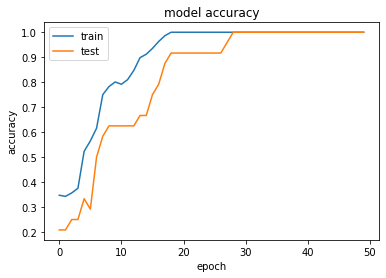

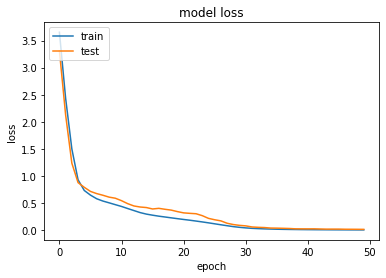

In [220]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [221]:
results = model3.evaluate(x_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 6ms/step - loss: 0.0136 - accuracy: 1.0000
[0.013557517901062965, 1.0]


With only 7 neurons, we managed to get 100% accuracy on both the train and test set 

Now let's see the quality of the prediction when only using the vectorized diagrams as inputs 

In [224]:
x,y = vect_diagrams[idx], labels[idx]

test_size= 60
x_test, y_test= x[:test_size], y[:test_size]
x_train, y_train= x[test_size:], y[test_size:]

In [225]:
model4= keras.Sequential(
    [
        Dense(32, activation='relu'),
        #Dense(512, activation='relu'),
        #Dense(128, activation='relu'),
        Dense(3, activation= 'softmax')
    ]
)

In [226]:
model4.compile(optimizer= 'adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics= ['accuracy'])

In [227]:
history= model4.fit(x= x_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
14/14 [==============================] - 1s 15ms/step - loss: 4.0250 - accuracy: 0.1620 - val_loss: 2.0423 - val_accuracy: 0.2917
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 1.2730 - accuracy: 0.5046 - val_loss: 0.9396 - val_accuracy: 0.4167
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.5436 - accuracy: 0.7500 - val_loss: 0.4271 - val_accuracy: 0.7917
Epoch 4/50
14/14 [==============================] - 0s 4ms/step - loss: 0.3165 - accuracy: 0.8750 - val_loss: 0.2827 - val_accuracy: 0.9167
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.2378 - accuracy: 0.9028 - val_loss: 0.2159 - val_accuracy: 0.9583
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1853 - accuracy: 0.9398 - val_loss: 0.1992 - val_accuracy: 0.9583
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1577 - accuracy: 0.9537 - val_loss: 0.1579 - val_accuracy: 1.0000
Epoch 8/50
14/14 [=

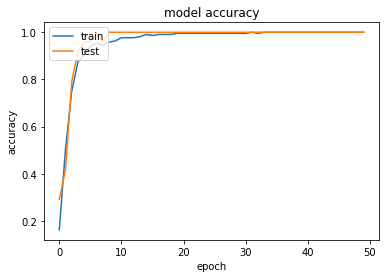

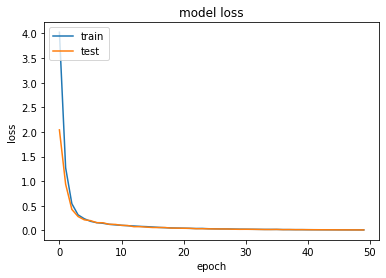

In [228]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [229]:
results = model4.evaluate(x_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 6ms/step - loss: 0.0114 - accuracy: 1.0000
[0.01137437392026186, 1.0]


We see that the topological features are enough to make a perfect classification on the dataset

Finally, let's see the performance when only using the point cloud data

In [231]:
x,y = data_all_scaled[idx], labels[idx]

test_size= 60
x_test, y_test= x[:test_size], y[:test_size]
x_train, y_train= x[test_size:], y[test_size:]

In [237]:
model5= keras.Sequential(
    [
        Dense(32, activation='relu'),
        #Dense(512, activation='relu'),
        #Dense(128, activation='relu'),
        Dense(3, activation= 'softmax')
    ]
)

In [238]:
model5.compile(optimizer= 'adam', metrics= ['accuracy'], loss= tf.keras.losses.CategoricalCrossentropy())

In [239]:
history= model5.fit(x= x_train, y= y_train, batch_size= 16, validation_split= 0.1, epochs= 50)

Epoch 1/50
14/14 [==============================] - 1s 15ms/step - loss: 0.7617 - accuracy: 0.5880 - val_loss: 0.5021 - val_accuracy: 0.7083
Epoch 2/50
14/14 [==============================] - 0s 4ms/step - loss: 0.2739 - accuracy: 0.8611 - val_loss: 0.2935 - val_accuracy: 0.8333
Epoch 3/50
14/14 [==============================] - 0s 4ms/step - loss: 0.1423 - accuracy: 0.9722 - val_loss: 0.1949 - val_accuracy: 0.9583
Epoch 4/50
14/14 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 1.0000 - val_loss: 0.1604 - val_accuracy: 0.9583
Epoch 5/50
14/14 [==============================] - 0s 4ms/step - loss: 0.0522 - accuracy: 1.0000 - val_loss: 0.1300 - val_accuracy: 0.9583
Epoch 6/50
14/14 [==============================] - 0s 4ms/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.1115 - val_accuracy: 0.9583
Epoch 7/50
14/14 [==============================] - 0s 4ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.0989 - val_accuracy: 0.9583
Epoch 8/50
14/14 [=

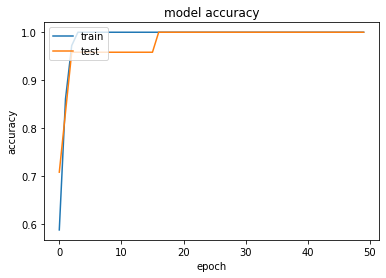

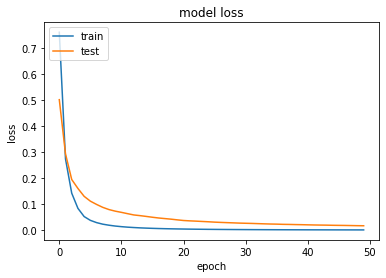

In [240]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [241]:
results = model5.evaluate(x_test, y_test, batch_size=32)
print(results)

2/2 [==============================] - 0s 7ms/step - loss: 0.0410 - accuracy: 1.0000
[0.04098306596279144, 1.0]


In order to achieve the same accuracy as model 4 on the test and  train set, the model that only use the original data as input need to be much bigger (here model5 has  ~13x more weights than model4)
